

# DISCOVERY DATA ANALYST TASK


Discovery (and other teams within the Foundation) rely on the event log (EL) to track a variety of performance and usage metrics to help us make decisions. Specifically, Discovery is interested in:

      Click-through rate: The proportion of search sessions in which the user clicked on one of the displayed results.
      Zero result rate: The proportion of searches that returned 0 results.

EL uses JavaScript to send messages (events) asynchronously to our servers when the user has performed specific actions.

With this data, an A/B test will be carried out to determine the best performance of the metrics of Group A or Group B, in particular we are going to analyze the following:

 - What is our daily overall clickthrough rate? How does it vary between the groups?
 - Which results do people tend to try first? How does it change day-to-day?
 - What is our daily overall zero results rate? How does it vary between the groups?
 - Let session length be approximately the time between the first event and the last event in a session,and visualizes the    relationship between the duration of the sessions with other variables 
 
The dataset comes from a tracking scheme used to assess user satisfaction. Desktop users are randomly sampled to be anonymously tracked by this scheme, which uses an "I'm live" ping system that allows us to estimate how long our users stay on the pages they visit. The dataset contains just over a week of EL data.

For clarifications on the variables of the dataset you can consult the following link
https://meta.wikimedia.org/wiki/Schema:TestSearchSatisfaction2

     .
So let's start with an exploratory data analysis of our dataset.



# 1. Exploratory data analysis

In [2]:
import pandas as pd
import numpy as np
import gzip
import csv
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Path to the compressed file
compressed_file_path = 'events_log.csv.gz'

# Create a list to store CSV data
data = []

# Open the compressed file in text read mode ('rt')
with gzip.open(compressed_file_path, 'rt', encoding='utf-8') as compressed_file:
    # Open the CSV file from the compressed file
    csv_reader = csv.reader(compressed_file)
    
    # Read rows from the CSV file and store them in the "data" list
    for row in csv_reader:
        data.append(row)

# Extract the first row as column names
column_names = data[0]

# Remove the first row from the data list (as it will be used as column names)
data = data[1:]

# Convert the data list into a Pandas DataFrame with column names
tracking = pd.DataFrame(data, columns=column_names)
tracking.head()


,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
0,00000736167c507e8ec225bd9e71f9e5,20160301103842,78245c2c3fba013a,b,searchResultPage,NA,cbeb66d1bc1f1bc2,5,NA
1,00000c69fe345268935463abbfa5d5b3,20160307005226,c559c3be98dca8a4,a,searchResultPage,NA,eb658e8722aad674,10,NA
2,00003bfdab715ee59077a3670331b787,20160302145305,760bf89817ce4b08,a,checkin,30,f99a9fc1f7fdd21e,NA,NA
3,0000465cd7c35ad2bdeafec953e08c1a,20160302222701,fb905603d31b2071,a,checkin,60,e5626962a6939a75,NA,10
4,000050cbb4ef5b42b16c4d2cf69e6358,20160302095023,c2bf5e5172a892dc,a,checkin,30,787dd6a4c371cbf9,NA,NA


In [4]:
tracking.shape

(400165, 9)

In [5]:
tracking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400165 entries, 0 to 400164
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   uuid             400165 non-null  object
 1   timestamp        400165 non-null  object
 2   session_id       400165 non-null  object
 3   group            400165 non-null  object
 4   action           400165 non-null  object
 5   checkin          400165 non-null  object
 6   page_id          400165 non-null  object
 7   n_results        400165 non-null  object
 8   result_position  400165 non-null  object
dtypes: object(9)
memory usage: 27.5+ MB


In [6]:
tracking.describe()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
count,400165,400165,400165,400165,400165,400165,400165,400165,400165
unique,400165,294302,68028,2,3,16,176371,93,194
top,00000736167c507e8ec225bd9e71f9e5,20160307144138,b254341e78af2f1a,a,checkin,NA,ffeae9d12ad83b25,NA,NA
freq,1,17,484,299019,223824,176341,24,263931,169683


It can be seen how the sample is divided quite equally into the two groups in terms of the number of sessions in each of them.

 - Group A = 29.427 sessions
 - Group A = 38.601 sessions

In [7]:
# Count the number of unique session_ids in each group
unique_sessions_by_group = tracking.groupby('group')['session_id'].nunique()
unique_sessions_by_group

group
a    29427
b    38601
Name: session_id, dtype: int64

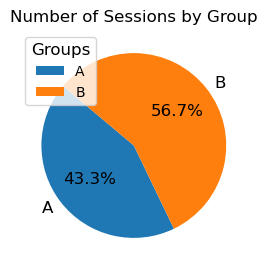

In [8]:
# Data
groups = unique_sessions_by_group.index
session_counts = unique_sessions_by_group.values

# Colors
colors = ['#1f77b4', '#ff7f0e']  # Blue for Group A, Orange for Group B

# Uppercase the labels
groups = [group.upper() for group in groups]

# Increase font size for values and legend
plt.rcParams['font.size'] = 12

# Create a pie chart
plt.figure(figsize=(3,3))
plt.pie(session_counts, labels=groups, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Number of Sessions by Group', fontsize=12)

# Add a legend with larger font size
plt.legend(groups, title="Groups", loc="upper left", fontsize=10)

# Show the chart
plt.show()

When trying to convert the timestamp column to date and time format, we see that it is not possible since there is erroneous data.

We identify them and see that they are values, it is decided to eliminate them.

In [9]:
# Try to convert the 'timestamp' column values to dates and catch errors
try:
    tracking['timestamp'] = pd.to_datetime(tracking['timestamp'], format='%Y%m%d%H%M%S', errors='raise')
except ValueError:
    # Capture conversion errors and store the rows with errors in a new DataFrame
    values_with_errors = tracking[pd.to_datetime(tracking['timestamp'], errors='coerce').isna()]

values_with_errors

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
40952,1a5b663f6a1258f588dc4de65c90b5c0,2.0160303e+13,35a29e7a78ccc24b,a,checkin,180,8f0d489715dd14b0,NA,NA
157636,6509e446fe7852fbb503af7d3453c6df,2.0160306e+13,aa89be8089ff5694,a,checkin,420,2ba84fc2f11fbc92,NA,1
221506,8d8ffe3bfba4516f9d0d8c1decbe1b76,2.0160307e+13,13cd6d70d0fa2b58,a,checkin,120,041d0e94cde215fd,NA,1
348288,deac7c11f00d598292f9e18ee2f6997f,2.0160304e+13,426b242692d66473,a,searchResultPage,NA,2ab3d9ca41b16173,20,NA


In [10]:
tracking = tracking.drop(values_with_errors.index)

In [11]:
tracking['timestamp'] = tracking['timestamp'].astype(str)  # Convert values to text strings

# Then the column is converted with the custom format
tracking['timestamp'] = pd.to_datetime(tracking['timestamp'], format='%Y%m%d%H%M%S')

In [12]:
tracking.shape

(400161, 9)

When calculating the durations of the sessions and exploring them, we see that there is a high number of sessions with duration 0, this may be due to bots or crawlers, and they can distort our statistics.

In addition, sessions lasting 5 days are observed, which can also be errors, so we must identify all these values and remove them from our dataset.

The criterion used will be to eliminate all sessions with duration 0 and those that are more than 60 minutes.

In [13]:
session_durations = tracking.groupby('session_id')['timestamp'].apply(lambda x: x.max() - x.min()).reset_index()

In [14]:
tracking_durations = tracking.merge(session_durations, on='session_id', suffixes=('', '_duration'))
tracking_durations.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,timestamp_duration
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42,78245c2c3fba013a,b,searchResultPage,NA,cbeb66d1bc1f1bc2,5,NA,0 days 00:00:44
1,004690364c695f04b5d045913e1bdf7c,2016-03-01 10:39:16,78245c2c3fba013a,b,checkin,30,2f0e04bd56649f43,NA,3,0 days 00:00:44
2,0af62216356759fea26313e155f70809,2016-03-01 10:39:26,78245c2c3fba013a,b,checkin,40,2f0e04bd56649f43,NA,3,0 days 00:00:44
3,14601aeb2bf058af9380c1644e606e24,2016-03-01 10:39:06,78245c2c3fba013a,b,checkin,20,2f0e04bd56649f43,NA,3,0 days 00:00:44
4,33922e14b6bb5e27823481a3c44ed462,2016-03-01 10:38:56,78245c2c3fba013a,b,checkin,10,2f0e04bd56649f43,NA,3,0 days 00:00:44


In [15]:
#Session with maximum duration
max_duration_session = tracking_durations.loc[tracking_durations['timestamp_duration'].idxmax()]
print(max_duration_session)
#Session with minimum duration
min_duration_session = tracking_durations.loc[tracking_durations['timestamp_duration'].idxmin()]
print(min_duration_session)

uuid                  02ea3000d0525711a8c45897f7b042a2
timestamp                          2016-03-03 20:37:09
session_id                            8cf57f4f99f96220
group                                                a
action                                searchResultPage
checkin                                             NA
page_id                               a0e3219e3590bef8
n_results                                           20
result_position                                     NA
timestamp_duration                     5 days 20:14:39
Name: 67895, dtype: object
uuid                  000104fe220a5675a270420cd6d4d4ac
timestamp                          2016-03-02 01:28:45
session_id                            485eabe5374f09e4
group                                                b
action                                searchResultPage
checkin                                             NA
page_id                               4da9a64232ce947b
n_results                             

In [16]:
# Sessions with 95th percentile duration
percentil_95 = tracking_durations['timestamp_duration'].quantile(0.95)

sesiones_percentil_95 = tracking_durations[tracking_durations['timestamp_duration'] < percentil_95]

# Maximum and minimum duration
duracion_maxima = sesiones_percentil_95['timestamp_duration'].max()
duracion_minima = sesiones_percentil_95['timestamp_duration'].min()

print(f"Maximum duration session in percentil 95: {duracion_maxima}")
print(f"Minimum duration sesssion in percentil 95: {duracion_minima}")

Maximum duration session in percentil 95: 0 days 00:21:20
Minimum duration sesssion in percentil 95: 0 days 00:00:00


In [17]:
# Calculate the total number of sessions
total_sessions = tracking_durations['session_id'].nunique()

# Filter sessions with a duration greater than 60 minutes
sessions_over_60_minutes = tracking_durations[tracking_durations['timestamp_duration'] > pd.Timedelta(minutes=60)]
total_sessions_over_60_minutes = sessions_over_60_minutes['session_id'].nunique()

# Filter sessions with a duration equal to 0 minutes
sessions_duration_0 = tracking_durations[tracking_durations['timestamp_duration'] == pd.Timedelta(minutes=0)]
total_sessions_duration_0 = sessions_duration_0['session_id'].nunique()

print(f"Total number of sessions: {total_sessions}")
print(f"Total number of sessions with a duration over 60 minutes: {total_sessions_over_60_minutes}")
print(f"Total number of sessions with a duration equal to 0 minutes: {total_sessions_duration_0}")


Total number of sessions: 68028
Total number of sessions with a duration over 60 minutes: 88
Total number of sessions with a duration equal to 0 minutes: 27606


In [18]:
#New dataset without outliers
tracking_ok = tracking_durations[(tracking_durations['timestamp_duration'] > pd.Timedelta(minutes=0)) & (tracking_durations['timestamp_duration'] <= pd.Timedelta(minutes=60))]
print(tracking_ok.shape)
tracking_ok.head()

(368372, 10)


,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,timestamp_duration
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42,78245c2c3fba013a,b,searchResultPage,NA,cbeb66d1bc1f1bc2,5,NA,0 days 00:00:44
1,004690364c695f04b5d045913e1bdf7c,2016-03-01 10:39:16,78245c2c3fba013a,b,checkin,30,2f0e04bd56649f43,NA,3,0 days 00:00:44
2,0af62216356759fea26313e155f70809,2016-03-01 10:39:26,78245c2c3fba013a,b,checkin,40,2f0e04bd56649f43,NA,3,0 days 00:00:44
3,14601aeb2bf058af9380c1644e606e24,2016-03-01 10:39:06,78245c2c3fba013a,b,checkin,20,2f0e04bd56649f43,NA,3,0 days 00:00:44
4,33922e14b6bb5e27823481a3c44ed462,2016-03-01 10:38:56,78245c2c3fba013a,b,checkin,10,2f0e04bd56649f43,NA,3,0 days 00:00:44


Now we see how the distribution of the number of sessions in the data set has changed a lot, but the sample is still representative so we can continue with our analysis.

In [19]:
#Count the number of unique session_ids in each group
unique_sessions_by_group_nooutliers = tracking_ok.groupby('group')['session_id'].nunique()
unique_sessions_by_group_nooutliers

group
a    29358
b    10976
Name: session_id, dtype: int64

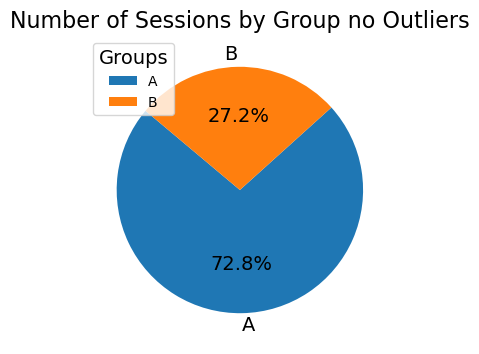

In [20]:
# Data
groups = unique_sessions_by_group_nooutliers.index
session_counts = unique_sessions_by_group_nooutliers.values

# Colors
colors = ['#1f77b4', '#ff7f0e']  # Blue for Group A, Orange for Group B

# Uppercase the labels
groups = [group.upper() for group in groups]

# Increase font size for values and legend
plt.rcParams['font.size'] = 14

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(session_counts, labels=groups, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Number of Sessions by Group no Outliers', fontsize=16)

# Add a legend with larger font size
plt.legend(groups, title="Groups", loc="upper left", fontsize=10)

# Show the chart
plt.show()

In [21]:
# Sessions with 95th percentile duration
percentil_95_ok = tracking_ok['timestamp_duration'].quantile(0.95)

sesiones_percentil_95_ok = tracking_ok[tracking_ok['timestamp_duration'] < percentil_95]

# Maximum and minimum duration
duracion_maxima = sesiones_percentil_95['timestamp_duration'].max()
duracion_minima = sesiones_percentil_95['timestamp_duration'].min()

print(f"Maximum duration session in percentil 95: {duracion_maxima}")
print(f"Minimum duration sesssion in percentil 95: {duracion_minima}")

Maximum duration session in percentil 95: 0 days 00:21:20
Minimum duration sesssion in percentil 95: 0 days 00:00:00


In [22]:
# Create the 'date' (date only) column
tracking_ok['date'] = tracking_ok['timestamp'].dt.date

# Create the 'day_of_week' (day of the week) column
tracking_ok['day_of_week'] = tracking_ok['timestamp'].dt.strftime('%A')

C:\Users\javierheras\AppData\Local\Temp\ipykernel_10048\1584011718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_ok['date'] = tracking_ok['timestamp'].dt.date
C:\Users\javierheras\AppData\Local\Temp\ipykernel_10048\1584011718.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_ok['day_of_week'] = tracking_ok['timestamp'].dt.strftime('%A')


In [23]:
tracking_ok.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,timestamp_duration,date,day_of_week
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42,78245c2c3fba013a,b,searchResultPage,NA,cbeb66d1bc1f1bc2,5,NA,0 days 00:00:44,2016-03-01,Tuesday
1,004690364c695f04b5d045913e1bdf7c,2016-03-01 10:39:16,78245c2c3fba013a,b,checkin,30,2f0e04bd56649f43,NA,3,0 days 00:00:44,2016-03-01,Tuesday
2,0af62216356759fea26313e155f70809,2016-03-01 10:39:26,78245c2c3fba013a,b,checkin,40,2f0e04bd56649f43,NA,3,0 days 00:00:44,2016-03-01,Tuesday
3,14601aeb2bf058af9380c1644e606e24,2016-03-01 10:39:06,78245c2c3fba013a,b,checkin,20,2f0e04bd56649f43,NA,3,0 days 00:00:44,2016-03-01,Tuesday
4,33922e14b6bb5e27823481a3c44ed462,2016-03-01 10:38:56,78245c2c3fba013a,b,checkin,10,2f0e04bd56649f43,NA,3,0 days 00:00:44,2016-03-01,Tuesday


In [24]:
# Filter the DataFrame for group 'a'
group_a_sessions = tracking_ok[tracking_ok['group'] == 'a']

# Count the number of unique session_id values for group 'a'
num_sessions_group_a = group_a_sessions['session_id'].nunique()

# Filter the DataFrame for group 'b'
group_b_sessions = tracking_ok[tracking_ok['group'] == 'b']

# Count the number of unique session_id values for group 'b'
num_sessions_group_b = group_b_sessions['session_id'].nunique()

print(f"Number of sessions for group 'a': {num_sessions_group_a}")
print(f"Number of sessions for group 'b': {num_sessions_group_b}")

Number of sessions for group 'a': 29358
Number of sessions for group 'b': 10976


C:\Users\javierheras\AppData\Local\Temp\ipykernel_10048\246754187.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_ok['timestamp'] = pd.to_datetime(tracking_ok['timestamp'])
C:\Users\javierheras\AppData\Local\Temp\ipykernel_10048\246754187.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_ok['date'] = tracking_ok['timestamp'].dt.date
C:\Users\javierheras\AppData\Local\Temp\ipykernel_10048\246754187.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

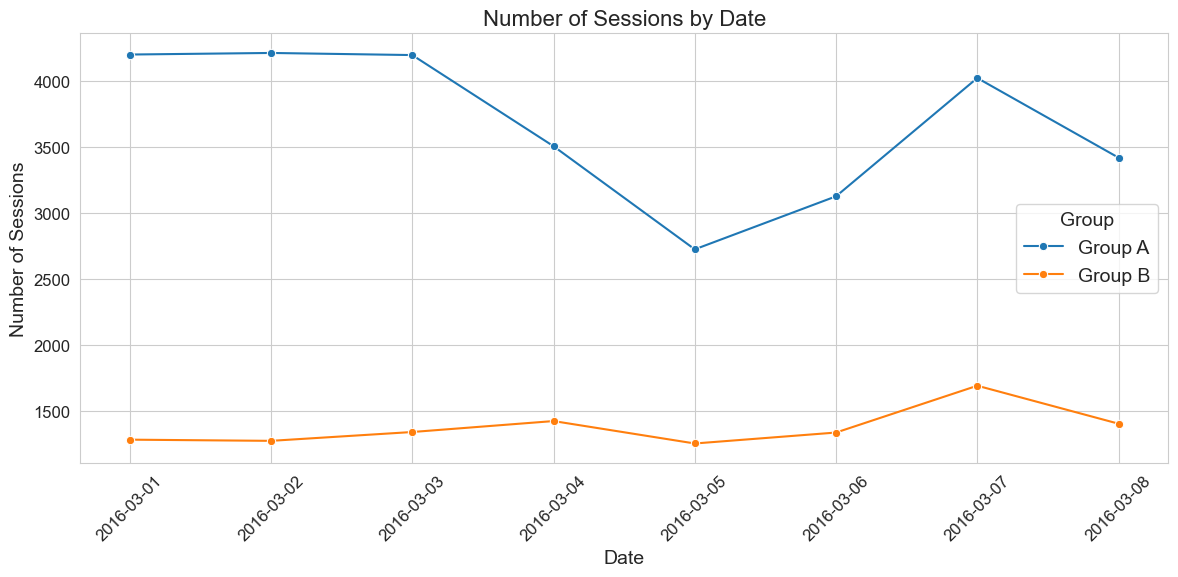

In [25]:
# Set the global font size
plt.rcParams['font.size'] = 14

# Rest of your code
sns.set_style("whitegrid")

# Convert the 'timestamp' column to a datetime object
tracking_ok['timestamp'] = pd.to_datetime(tracking_ok['timestamp'])

# Extract the date and day of the week
tracking_ok['date'] = tracking_ok['timestamp'].dt.date
tracking_ok['day_of_week'] = tracking_ok['timestamp'].dt.day_name()

# Define the start date
start_date = pd.to_datetime('2016-03-01').date()

# Group the data by date and group, then count unique session_ids
grouped_data = tracking_ok.groupby(['date', 'group'])['session_id'].nunique().reset_index()

# Pivot the data to have 'date' as the index and 'group' as columns
pivot_data = grouped_data.pivot(index='date', columns='group', values='session_id').fillna(0)

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot_data, x=pivot_data.index, y='a', label='Group A', marker='o')
sns.lineplot(data=pivot_data, x=pivot_data.index, y='b', label='Group B', marker='o')

# Customize the plot
plt.title('Number of Sessions by Date', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Sessions', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Group', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

# 2. Calculation of the most relevant metrics

Once we have done our data exploration, in which we have understood what data we have, what it means and the data formats, we will proceed to calculate the main metrics.

With these we can make decisions as to how the two groups are performing in our A/B test.

The metrics we are going to calculate are the ones detailed above, and we are going to start with the clickthrough rate.



## 2.1 What is our daily overall clickthrough rate? How does it vary between the groups?


The clickthrough rate is the number of sessions in which at least one click has occurred.

There are sessions with numerous searches, and in them there may or may not be clicks, but what we are looking for are the sessions, whether they have many searches or just one, in which at least one click has been made.

To do this, you have to see the sessions in which the Visitpage action exists, this would be our click.

In [26]:
tracking_sorted = tracking_ok.sort_values(by=['group','session_id','timestamp'])
tracking_sorted.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,timestamp_duration,date,day_of_week
362904,dd69b85b8d2e5cfba4e3f5d1a0fff2b3,2016-03-08 16:19:46,000216cf18ae1ab1,a,searchResultPage,NA,08cebdafafbe069a,20,NA,0 days 00:00:58,2016-03-08,Tuesday
362902,77597848127959adb57d21160eff8b81,2016-03-08 16:19:53,000216cf18ae1ab1,a,searchResultPage,NA,a9e6d0d61a634ea4,20,NA,0 days 00:00:58,2016-03-08,Tuesday
362901,708e9a7812fe5559a2f26f229f86ed42,2016-03-08 16:20:32,000216cf18ae1ab1,a,searchResultPage,NA,fdce0b86340b3276,20,NA,0 days 00:00:58,2016-03-08,Tuesday
362900,56de2bdd4ca05ad3a3bab8402c1a4aea,2016-03-08 16:20:38,000216cf18ae1ab1,a,searchResultPage,NA,073960884b538560,20,NA,0 days 00:00:58,2016-03-08,Tuesday
362905,f69cc8cb90bb51bfae9978b065ca8310,2016-03-08 16:20:43,000216cf18ae1ab1,a,searchResultPage,NA,044c957ac8a03a55,20,NA,0 days 00:00:58,2016-03-08,Tuesday


In [27]:
visit_page_sessions = tracking_ok[tracking_ok['action'] == 'visitPage']
# Unique sessions in the 'session_id' column within the 'visit_page_sessions' subset
unique_sessions_with_visit_page = visit_page_sessions['session_id'].nunique()

In [28]:
# Total unique sessions
total_unique_sessions = tracking_ok['session_id'].nunique()

In [29]:
# Calculate the percentage of unique sessions with at least one 'visitPage'
percentage_sessions_with_visit_page = (unique_sessions_with_visit_page / total_unique_sessions) * 100

print("clickthrough rate:", percentage_sessions_with_visit_page)

clickthrough rate: 65.3716467496405


We are going to calculate the clickthrough rate for each group.

Then we are going to calculate how this varies over time, as we only have data from a little more than a week, we calculate it and represent it in a graph.

In [30]:
tracking_a = tracking_ok[tracking_ok['group'] == 'a']
visit_page_sessions_a = tracking_a[tracking_a['action'] == 'visitPage']
unique_sessions_with_visit_page_a = visit_page_sessions_a['session_id'].nunique()
total_unique_sessions_a = tracking_a['session_id'].nunique()
percentage_sessions_with_visit_page_a = (unique_sessions_with_visit_page_a / total_unique_sessions_a) * 100

print("clickthrough rate group A:", percentage_sessions_with_visit_page_a)

clickthrough rate group A: 66.91191498058451


In [31]:
tracking_b = tracking_ok[tracking_ok['group'] == 'b']
visit_page_sessions_b = tracking_b[tracking_b['action'] == 'visitPage']
unique_sessions_with_visit_page_b = visit_page_sessions_b['session_id'].nunique()
total_unique_sessions_b = tracking_b['session_id'].nunique()
percentage_sessions_with_visit_page_b = (unique_sessions_with_visit_page_b / total_unique_sessions_b) * 100

print("clickthrough rate group B:", percentage_sessions_with_visit_page_b)

clickthrough rate group B: 61.2518221574344


In [32]:
daily_unique_sessions_with_visit_page_a = visit_page_sessions_a.groupby(tracking_a['timestamp'].dt.date)['session_id'].nunique()
daily_total_unique_sessions_a = tracking_a.groupby(tracking_a['timestamp'].dt.date)['session_id'].nunique()
daily_percentage_sessions_with_visit_page_a = (daily_unique_sessions_with_visit_page_a / daily_total_unique_sessions_a) * 100

In [33]:
daily_unique_sessions_with_visit_page_b = visit_page_sessions_b.groupby(tracking_b['timestamp'].dt.date)['session_id'].nunique()
daily_total_unique_sessions_b = tracking_b.groupby(tracking_b['timestamp'].dt.date)['session_id'].nunique()
daily_percentage_sessions_with_visit_page_b = (daily_unique_sessions_with_visit_page_b / daily_total_unique_sessions_b) * 100

In [34]:
# Filter data for Group A
group_a_data = tracking_ok[tracking_ok['group'] == 'a']

# Calculate the daily clickthrough rate for Group A
daily_percentage_sessions_with_visit_page_group_a = (group_a_data[group_a_data['action'] == 'visitPage'].groupby('date')['session_id'].nunique() / group_a_data[group_a_data['action'] == 'searchResultPage'].groupby('date')['session_id'].nunique() * 100).fillna(0)

# Create a DataFrame for Group A
df_percentage_group_a = pd.DataFrame({'date': daily_percentage_sessions_with_visit_page_group_a.index, 'Percentage Group A': daily_percentage_sessions_with_visit_page_group_a.values})

# Filter data for Group B
group_b_data = tracking_ok[tracking_ok['group'] == 'b']

# Calculate the daily clickthrough rate for Group B
daily_percentage_sessions_with_visit_page_group_b = (group_b_data[group_b_data['action'] == 'visitPage'].groupby('date')['session_id'].nunique() / group_b_data[group_b_data['action'] == 'searchResultPage'].groupby('date')['session_id'].nunique() * 100).fillna(0)

# Create a DataFrame for Group B
df_percentage_group_b = pd.DataFrame({'date': daily_percentage_sessions_with_visit_page_group_b.index, 'Percentage Group B': daily_percentage_sessions_with_visit_page_group_b.values})


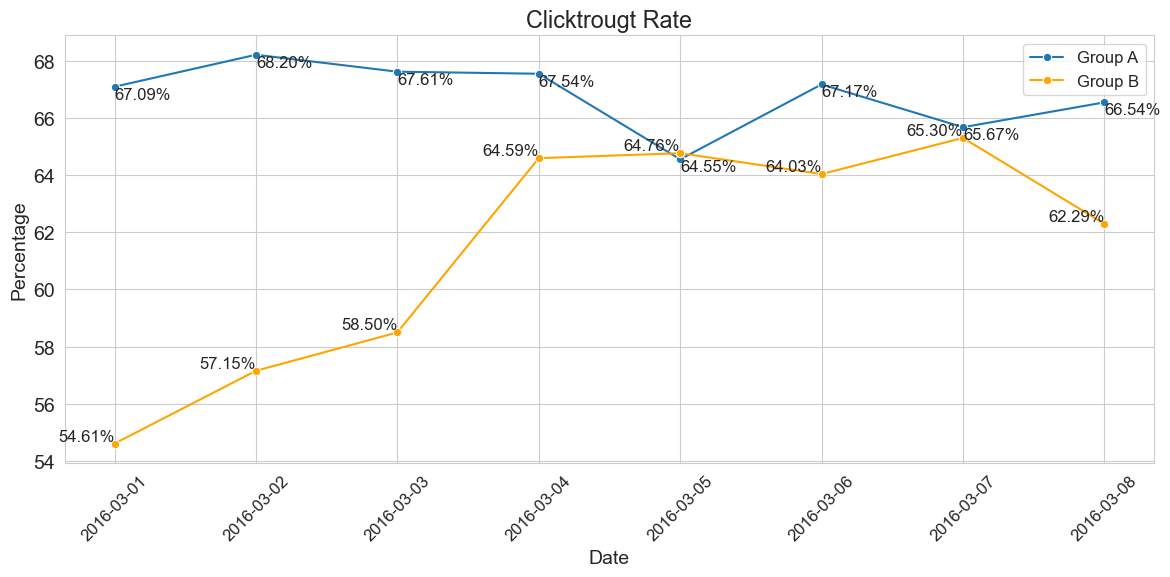

In [35]:
# Seaborn style
sns.set_style("whitegrid")

# The seaborn line chart is created for Group A
plt.figure(figsize=(12, 6)) 
sns.lineplot(x='date', y='Percentage Group A', data=df_percentage_group_a, marker='o', label='Group A')

# The seaborn line chart is created for Group B
sns.lineplot(x='date', y='Percentage Group B', data=df_percentage_group_b, marker='o', label='Group B', color='orange')

# Customization of titles and legends
plt.title('Clicktrougt Rate')
plt.xlabel('Date', fontsize=14)  
plt.ylabel('Percentage', fontsize=14)  
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=14)  
plt.legend(fontsize=16)  

# Show the values above the line for Group A with larger font size
for index, row in df_percentage_group_a.iterrows():
    plt.text(row['date'], row['Percentage Group A'], f"{row['Percentage Group A']:.2f}%", ha='left', va='top', fontsize=12)

# Show the values below the line for Group B with larger font size
for index, row in df_percentage_group_b.iterrows():
    plt.text(row['date'], row['Percentage Group B'], f"{row['Percentage Group B']:.2f}%", ha='right', va='bottom', fontsize=12)

# Increase overall legend font size
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


As can be seen in the graph, in the data calculated above, the clickthrough rate of Group A is higher than that of Group B.

If we look throughout the week, at the beginning of the week there is a big difference in the clickthrough rate of the two groups, improving the ratio in Group B even surpassing that of Group A on Saturday, but being better on average in Group A.

# 2.2 Which results do people tend to try first? How does it change day-to-day?

When a search is performed on the website, some results usually appear, now we are going to measure the tendency of the people who visit them to click on the links that appear, verifying which is the position of the link that is clicked the most.

That is to say, the position of the link on which users click most frequently.

In [36]:
total_valores_result_position = visit_page_sessions['result_position'].value_counts()

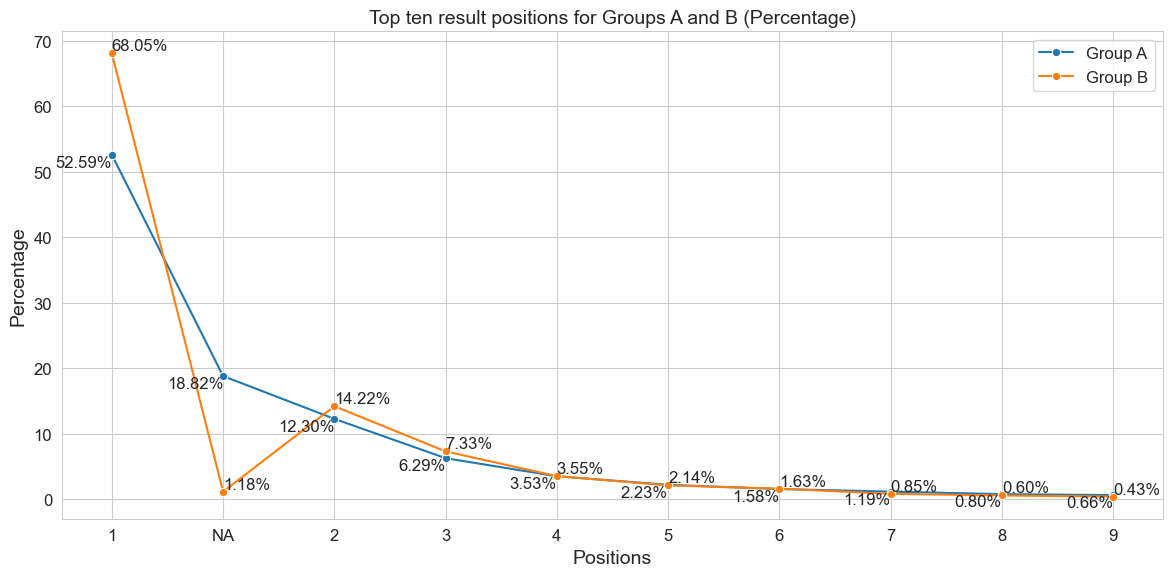

In [37]:
# Calculate the result_position counts for each group
total_valores_result_position_a = visit_page_sessions[visit_page_sessions['group'] == 'a']['result_position'].value_counts().head(10)
total_valores_result_position_b = visit_page_sessions[visit_page_sessions['group'] == 'b']['result_position'].value_counts().head(10)

# Calculate the total counts for normalization
total_counts_group_a = total_valores_result_position_a.sum()
total_counts_group_b = total_valores_result_position_b.sum()

# Calculate the percentages for each result position
percentages_group_a = (total_valores_result_position_a / total_counts_group_a) * 100
percentages_group_b = (total_valores_result_position_b / total_counts_group_b) * 100

# Create DataFrames for each group with percentages
df_a = pd.DataFrame({'Result Position': total_valores_result_position_a.index, 'Percentage Group A': percentages_group_a.values})
df_b = pd.DataFrame({'Result Position': total_valores_result_position_b.index, 'Percentage Group B': percentages_group_b.values})

# Create the line chart
plt.figure(figsize=(12, 6))

# Line for Group A
ax = sns.lineplot(data=df_a, x='Result Position', y='Percentage Group A', marker='o', label='Group A')

# Add labels with percentage values for Group A
for x, y in zip(df_a['Result Position'], df_a['Percentage Group A']):
    ax.text(x, y, f'{y:.2f}%', ha='right', va='top', fontsize=12)

# Line for Group B
ax = sns.lineplot(data=df_b, x='Result Position', y='Percentage Group B', marker='o', label='Group B')

# Add labels with percentage values for Group B
for x, y in zip(df_b['Result Position'], df_b['Percentage Group B']):
    ax.text(x, y, f'{y:.2f}%', ha='left', va='bottom', fontsize=12)

plt.title('Top ten result positions for Groups A and B (Percentage)', fontsize=14)
plt.xlabel('Positions', fontsize=14)  
plt.ylabel('Percentage', fontsize=14)  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.legend(fontsize=12)  
plt.grid(True)
plt.tight_layout()
plt.show()



As you can see, the link in position 1 is the one that people tend to click on the most, both in group A and group B as well.

Group A : 52,59 %.
Group B : 68,05 %.

In this case, in group b, people use more the link located in position 1, we can see how in group A, a percentage of 18,82 % use results with value N/A, which is much lower in group B.

C:\Users\javierheras\AppData\Local\Temp\ipykernel_10048\2046557688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visit_page_sessions['Date'] = visit_page_sessions['timestamp'].dt.date


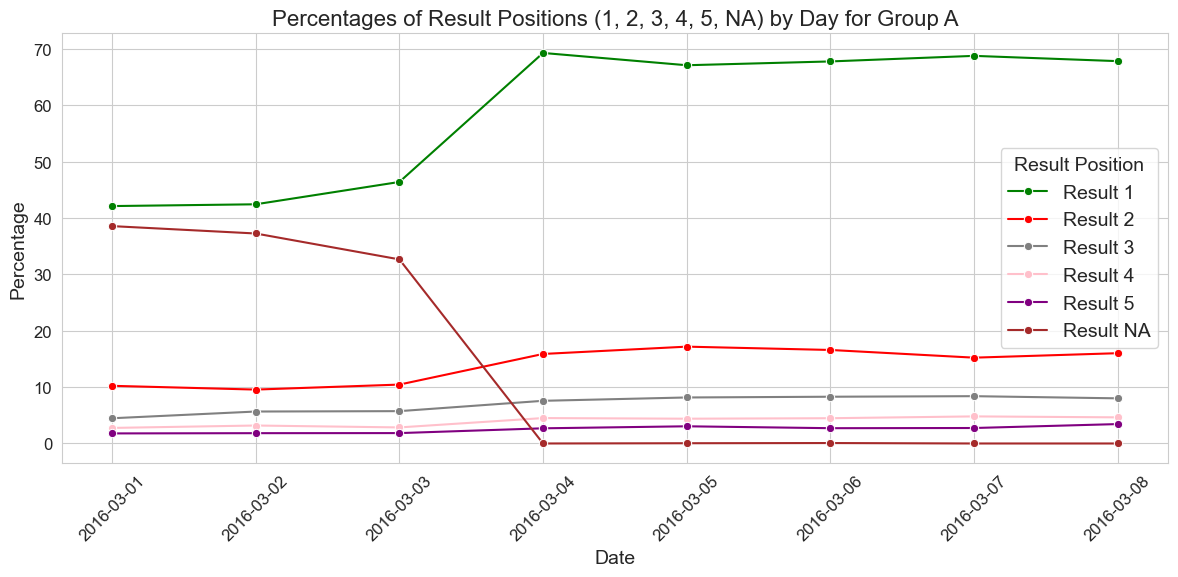

In [101]:
# Set the global font size
plt.rcParams['font.size'] = 14

# Create a new 'Date' column containing only the date (without the time)
visit_page_sessions['Date'] = visit_page_sessions['timestamp'].dt.date

# Filter the DataFrame for group 'a'
group_a_sessions = visit_page_sessions[visit_page_sessions['group'] == 'a']

# Filter the 'result_position' column for positions 1, 2, 3, 4, 5, and 'NA'
positions_to_include = ['1', '2', '3', '4', '5', 'NA']
group_a_filtered = group_a_sessions[group_a_sessions['result_position'].isin(positions_to_include)]

# Calculate the total count of 'result_position' for each day for Group A
total_counts_group_a = group_a_filtered.groupby('Date')['result_position'].count()

# Calculate the percentages of each 'result_position' for Group A
result_position_percentages_group_a = group_a_filtered.groupby(['Date', 'result_position'])['result_position'].count() / total_counts_group_a * 100

# Pivot the result to have 'Date' as index and 'result_position' as columns
result_position_percentages_group_a = result_position_percentages_group_a.unstack(fill_value=0)

custom_colors = ['green', 'red', 'gray', 'pink', 'purple', 'brown']

# Create line chart for Group A with custom colors
plt.figure(figsize=(12, 6))
for column, color in zip(result_position_percentages_group_a.columns, custom_colors):
    sns.lineplot(data=result_position_percentages_group_a[column], label=f'Result {column}', marker='o', color=color)

plt.title('Percentages of Result Positions (1, 2, 3, 4, 5, NA) by Day for Group A', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Result Position', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


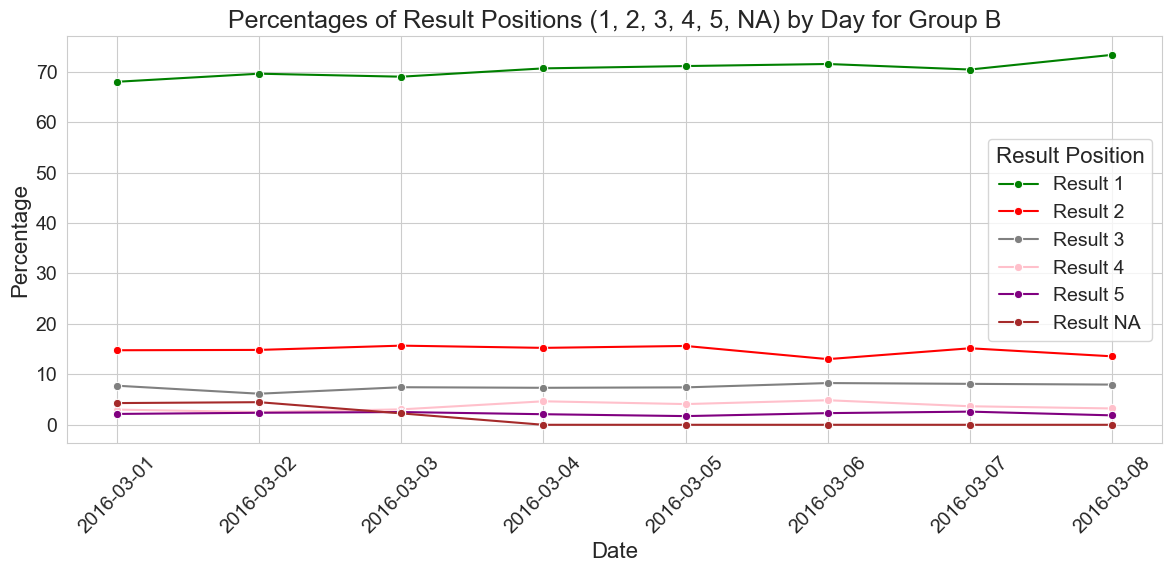

In [102]:
# Set the global font size
plt.rcParams['font.size'] = 16  # Increase font size for all text elements

# Filter the DataFrame for group 'b'
group_b_sessions = visit_page_sessions[visit_page_sessions['group'] == 'b']

# Filter the 'result_position' column for positions 1, 2, 3, 4, 5, and 'NA'
positions_to_include = ['1', '2', '3', '4', '5', 'NA']
group_b_filtered = group_b_sessions[group_b_sessions['result_position'].isin(positions_to_include)]

# Calculate the total count of 'result_position' for each day for Group B
total_counts_group_b = group_b_filtered.groupby('Date')['result_position'].count()

# Calculate the percentages of each 'result_position' for Group B
result_position_percentages_group_b = group_b_filtered.groupby(['Date', 'result_position'])['result_position'].count() / total_counts_group_b * 100

# Pivot the result to have 'Date' as index and 'result_position' as columns
result_position_percentages_group_b = result_position_percentages_group_b.unstack(fill_value=0)

# Define custom colors for the lines
custom_colors = ['green', 'red', 'gray', 'pink', 'purple', 'brown']

# Create line chart for Group B with custom colors
plt.figure(figsize=(12, 6))
for column, color in zip(result_position_percentages_group_b.columns, custom_colors):
    sns.lineplot(data=result_position_percentages_group_b[column], label=f'Result {column}', marker='o', color=color)

plt.title('Percentages of Result Positions (1, 2, 3, 4, 5, NA) by Day for Group B', fontsize=18)  # Increase title font size
plt.xlabel('Date', fontsize=16)  # Increase x-axis label font size
plt.ylabel('Percentage', fontsize=16)  # Increase y-axis label font size
plt.legend(title='Result Position', fontsize=14, title_fontsize=16)  # Increase legend font size
plt.grid(True)
plt.xticks(rotation=45, fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.tight_layout()
plt.show()


Analysing how this varied throughout the week, we see how the distribution remains stable with respect to the most used limk throughout the week, which is the link located in position 1 for both groups.

We can see, however, that in both groups A and B, on Friday 04/03/2016 the number of people using the link in position N/A drops to practically 0, with this drop being more pronounced in group A, as the number of people using this position was very high at the beginning of the week.

## 2.3 What is our daily overall zero results rate? How does it vary between the groups?

Now we are going to calculate the zero result rate, what this ratio represents is the percentage of searches in which no results appear.

That is to say, what the user is trying to search for is not found or has not been found on the website.

In [40]:
# Filter rows with "searchResultPage" equal to 0 results
zero_results = tracking_ok[(tracking_ok['action'] == 'searchResultPage') & (tracking_ok['n_results'] == '0')]
total_search = tracking_ok[tracking_ok['action'] == 'searchResultPage']

# Calculate the proportions
prop_zero_results = len(zero_results) / len(total_search)

# Show proportions
print("Proporción de 'searchResultPage' con 0 resultados:", prop_zero_results)


Proporción de 'searchResultPage' con 0 resultados: 0.1739007997596966


In [41]:
# Filter rows for Group A with "searchResultPage" equal to 0 results
zero_results_group_a = tracking_ok[(tracking_ok['action'] == 'searchResultPage') & (tracking_ok['n_results'] == '0') & (tracking_ok['group'] == 'a')]
total_search_group_a = tracking_ok[(tracking_ok['action'] == 'searchResultPage') & (tracking_ok['group'] == 'a')]

# Calculate the proportions for Group A
prop_zero_results_group_a = len(zero_results_group_a) / len(total_search_group_a)

# Filter rows for Group B with "searchResultPage" equal to 0 results
zero_results_group_b = tracking_ok[(tracking_ok['action'] == 'searchResultPage') & (tracking_ok['n_results'] == '0') & (tracking_ok['group'] == 'b')]
total_search_group_b = tracking_ok[(tracking_ok['action'] == 'searchResultPage') & (tracking_ok['group'] == 'b')]

# Calculate the proportions for Group B
prop_zero_results_group_b = len(zero_results_group_b) / len(total_search_group_b)

# Show proportions for both Group A and Group B
print("Proportion of 'searchResultPage' with 0 results for Group A:", prop_zero_results_group_a)
print("Proportion of 'searchResultPage' with 0 results for Group B:", prop_zero_results_group_b)



Proportion of 'searchResultPage' with 0 results for Group A: 0.17926121841175294
Proportion of 'searchResultPage' with 0 results for Group B: 0.14474797534147227


In [103]:
# Filter rows for Group A with "searchResultPage" equal to 0 results
zero_results_group_a = tracking_ok[(tracking_ok['action'] == 'searchResultPage') & (tracking_ok['n_results'] == '0') & (tracking_ok['group'] == 'a')]

# Group the data by date
grouped_by_date = zero_results_group_a.groupby(zero_results_group_a['timestamp'].dt.date)

# Calculate the percentages for each date
percentages_by_date = (grouped_by_date.size() / tracking_ok[(tracking_ok['action'] == 'searchResultPage') & (tracking_ok['group'] == 'a')].groupby(tracking_ok['timestamp'].dt.date).size()) * 100

# Show percentages for each date
print("Percentages of 'searchResultPage' with 0 results for Group A by date:")
print(percentages_by_date)


Percentages of 'searchResultPage' with 0 results for Group A by date:
timestamp
2016-03-01    18.116469
2016-03-02    18.568604
2016-03-03    17.233085
2016-03-04    17.390911
2016-03-05    17.612757
2016-03-06    17.081012
2016-03-07    18.256304
2016-03-08    18.927239
dtype: float64


In [104]:
# Filter rows for Group B with "searchResultPage" equal to 0 results
zero_results_group_b = tracking_ok[(tracking_ok['action'] == 'searchResultPage') & (tracking_ok['n_results'] == '0') & (tracking_ok['group'] == 'b')]

# Group the data by date
grouped_by_date_b = zero_results_group_b.groupby(zero_results_group_b['timestamp'].dt.date)

# Calculate the percentages for each date for Group B
percentages_by_date_b = (grouped_by_date_b.size() / tracking_ok[(tracking_ok['action'] == 'searchResultPage') & (tracking_ok['group'] == 'b')].groupby(tracking_ok['timestamp'].dt.date).size()) * 100

# Show percentages for each date for Group B
print("Percentages of 'searchResultPage' with 0 results for Group B by date:")
print(percentages_by_date_b)



Percentages of 'searchResultPage' with 0 results for Group B by date:
timestamp
2016-03-01    15.719229
2016-03-02    14.842958
2016-03-03    14.685990
2016-03-04    13.508260
2016-03-05    14.510870
2016-03-06    13.424519
2016-03-07    14.153599
2016-03-08    15.000000
dtype: float64


As we see, the distribution is quite homogeneous in the ratio throughout the entire week.

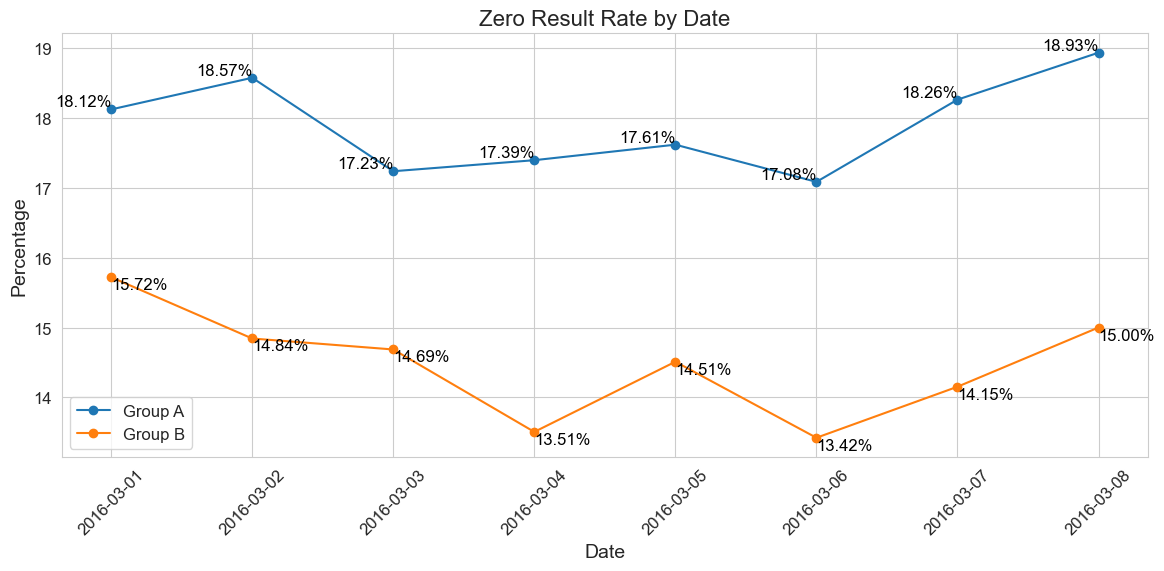

In [105]:
# Data for Group A
dates_a = percentages_by_date.index
percentages_a = percentages_by_date.values

# Data for Group B
dates_b = percentages_by_date_b.index
percentages_b = percentages_by_date_b.values

# Create the line chart
plt.figure(figsize=(12, 6))

# Line for Group A
plt.plot(dates_a, percentages_a, marker='o', label='Group A', linestyle='-')

# Line for Group B
plt.plot(dates_b, percentages_b, marker='o', label='Group B', linestyle='-')

# Add data values for Group A
for x, y in zip(dates_a, percentages_a):
    plt.text(x, y, f'{y:.2f}%', ha='right', va='bottom', fontsize=12, color='black')

# Add data values for Group B
for x, y in zip(dates_b, percentages_b):
    plt.text(x, y, f'{y:.2f}%', ha='left', va='top', fontsize=12, color='black')

# Customize the chart
plt.title("Zero Result Rate by Date", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Percentage", fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels and adjust font size
plt.yticks(fontsize=12)  # Adjust font size of y-axis values
plt.legend(fontsize=12)  # Adjust font size of the legend

# Show the chart
plt.grid(True)
plt.tight_layout()
plt.show()



Now we are going to calculate, just to have it as a reference in number of results in each search, and we are going to keep the 10 that you have most frequently.

This way we can know the position occupied by the searches that result or, having a general idea of whether that percentage is high or not, comparing it with other results.

As we see, searches with results occupy the second position, with only more searches that give 20 results.

In [81]:
# Filter data for Group A
group_a_data = tracking_ok[tracking_ok['group'] == 'a']

# Filter rows with "searchResultPage" equal to 0 results for Group A
zero_results_group_a = group_a_data[(group_a_data['action'] == 'searchResultPage') & (group_a_data['n_results'] == '0')]
total_search_group_a = group_a_data[group_a_data['action'] == 'searchResultPage']

# Calculate the proportions for Group A
prop_zero_results_group_a = len(zero_results_group_a) / len(total_search_group_a)

# Show proportions for Group A
print("Proportion of 'searchResultPage' with 0 results for Group A:", prop_zero_results_group_a)

# Get the 10 highest values and the rest grouped as "Other" for Group A
top_10_group_a = total_search_group_a['n_results'].value_counts().head(10)
otros_group_a = total_search_group_a[~total_search_group_a['n_results'].isin(top_10_group_a.index)].shape[0]

# Calculate the total for Group A
total_group_a = top_10_group_a.sum() + otros_group_a

# Calculate the percentages for Group A
porcentajes_group_a = [(val / total_group_a) * 100 for val in top_10_group_a.values] + [otros_group_a / total_group_a * 100]

# Create a DataFrame with the 10 highest values and "Other" along with the percentages for Group A
data_group_a = pd.DataFrame({
    'n_results Value': top_10_group_a.index.tolist() + ['Others'],
    'Percentage': porcentajes_group_a,
    'Frequency': top_10_group_a.values.tolist() + [otros_group_a]
})

# Display the result for Group A
print("\nGroup A:")
print(data_group_a)


Proportion of 'searchResultPage' with 0 results for Group A: 0.17926121841175294

Group A:
   n_results Value  Percentage  Frequency
0               20   58.263508      52429
1                0   17.926122      16131
2                1    5.057453       4551
3                2    3.177161       2859
4                3    2.233681       2010
5                4    1.693597       1524
6                5    1.508012       1357
7                6    1.233525       1110
8                7    1.043496        939
9                8    0.955704        860
10          Others    6.907741       6216


Proportion of 'searchResultPage' with 0 results for Group B: 0.14474797534147227


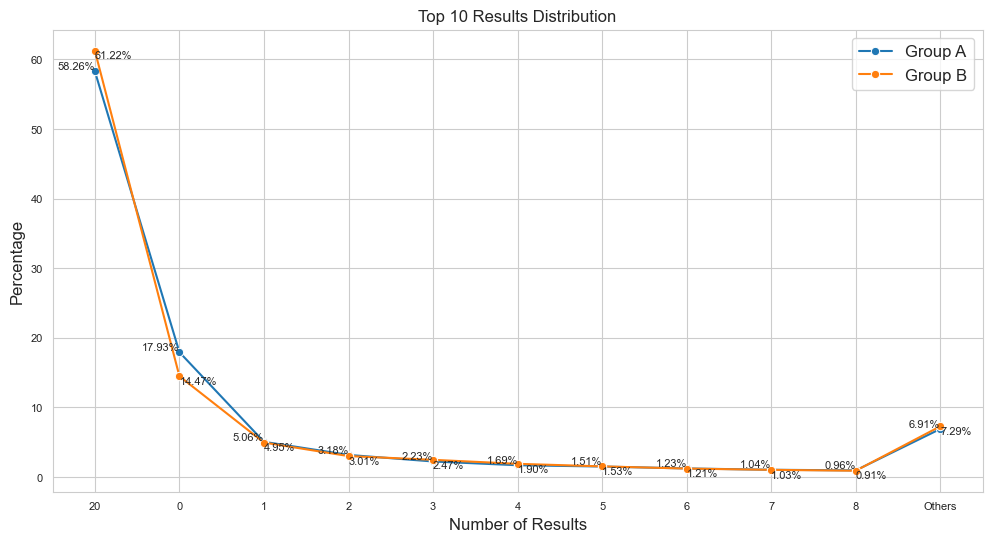

In [96]:
# Filter data for Group B
group_b_data = tracking_ok[tracking_ok['group'] == 'b']

# Filter rows with "searchResultPage" equal to 0 results for Group B
zero_results_group_b = group_b_data[(group_b_data['action'] == 'searchResultPage') & (group_b_data['n_results'] == '0')]
total_search_group_b = group_b_data[group_b_data['action'] == 'searchResultPage']

# Calculate the proportions for Group B
prop_zero_results_group_b = len(zero_results_group_b) / len(total_search_group_b)

# Show proportions for Group B
print("Proportion of 'searchResultPage' with 0 results for Group B:", prop_zero_results_group_b)

# Get the 10 highest values and the rest grouped as "Other" for Group B
top_10_group_b = total_search_group_b['n_results'].value_counts().head(10)
otros_group_b = total_search_group_b[~total_search_group_b['n_results'].isin(top_10_group_b.index)].shape[0]

# Calculate the total for Group B
total_group_b = top_10_group_b.sum() + otros_group_b

# Calculate the percentages for Group B
porcentajes_group_b = [(val / total_group_b) * 100 for val in top_10_group_b.values] + [otros_group_b / total_group_b * 100]

# Create a DataFrame with the 10 highest values and "Other" along with the percentages for Group B
data_group_b = pd.DataFrame({
    'n_results Value': top_10_group_b.index.tolist() + ['Others'],
    'Percentage': porcentajes_group_b,
    'Frequency': top_10_group_b.values.tolist() + [otros_group_b]
})

# Create the line chart for both Group A and Group B
plt.figure(figsize=(12, 6))
sns.lineplot(x='n_results Value', y='Percentage', data=data_group_a, marker='o', label='Group A', sort=False)
sns.lineplot(x='n_results Value', y='Percentage', data=data_group_b, marker='o', label='Group B', sort=False)

# Add labels with values for Group A with a smaller font size
for x, y in zip(data_group_a['n_results Value'], data_group_a['Percentage']):
    plt.text(x, y, f'{y:.2f}%', ha='right', va='bottom', fontsize=8)  # Fontsize 8

# Add labels with values for Group B with a smaller font size
for x, y in zip(data_group_b['n_results Value'], data_group_b['Percentage']):
    plt.text(x, y, f'{y:.2f}%', ha='left', va='top', fontsize=8)  # Fontsize 8

plt.title('Top 10 Results Distribution', fontsize=12)
plt.xlabel('Number of Results', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(fontsize=12)

# Reduce the font size of the numbers on the x and y axes
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()


In [97]:
# Filter the DataFrame by "searchResultPage" and "n_results" equal to '0' for Group A
zero_results_group_a = tracking_ok[(tracking_ok['action'] == 'searchResultPage') & (tracking_ok['n_results'] == '0') & (tracking_ok['group'] == 'a')]

# Filter the DataFrame by "searchResultPage" for Group A
total_search_group_a = tracking_ok[(tracking_ok['action'] == 'searchResultPage') & (tracking_ok['group'] == 'a')]

# Filter the DataFrame by "searchResultPage" and "n_results" equal to '0' for Group B
zero_results_group_b = tracking_ok[(tracking_ok['action'] == 'searchResultPage') & (tracking_ok['n_results'] == '0') & (tracking_ok['group'] == 'b')]

# Filter the DataFrame by "searchResultPage" for Group B
total_search_group_b = tracking_ok[(tracking_ok['action'] == 'searchResultPage') & (tracking_ok['group'] == 'b')]

# Calculate the proportions
prop_zero_results_a = len(zero_results_group_a) / len(total_search_group_a)
prop_zero_results_b = len(zero_results_group_b) / len(total_search_group_b)

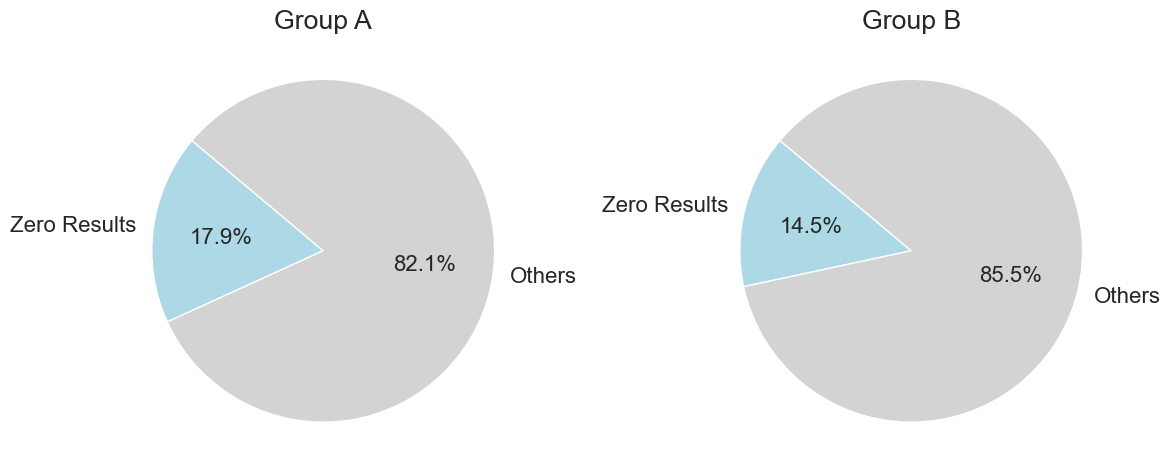

In [98]:
# Data
proportions = [prop_zero_results_group_a, prop_zero_results_group_b]
groups = ['Group A', 'Group B']

# Colors (pink and gray)
colors = ['#ADD8E6', '#D3D3D3']  # Pink and Gray

# Create a pie chart for Group A
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie([prop_zero_results_group_a, 1 - prop_zero_results_group_a], labels=['Zero Results', 'Others'], colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Group A')

# Create a pie chart for Group B
plt.subplot(1, 2, 2)
plt.pie([prop_zero_results_group_b, 1 - prop_zero_results_group_b], labels=['Zero Results', 'Others'], colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Group B')

# Show the charts
plt.tight_layout()
plt.show()


## 2.4 Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.

In this section we are going to compare the duration of the sessions with other variables in our data set.

The first thing we are going to calculate is the average duration of the sessions in each group, to know how much time users spend in each group.

Once the above is calculated, we will see how it varies throughout the week.

In [69]:
tracking_ok.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,timestamp_duration,date,day_of_week
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42,78245c2c3fba013a,b,searchResultPage,NA,cbeb66d1bc1f1bc2,5,NA,0 days 00:00:44,2016-03-01,Tuesday
1,004690364c695f04b5d045913e1bdf7c,2016-03-01 10:39:16,78245c2c3fba013a,b,checkin,30,2f0e04bd56649f43,NA,3,0 days 00:00:44,2016-03-01,Tuesday
2,0af62216356759fea26313e155f70809,2016-03-01 10:39:26,78245c2c3fba013a,b,checkin,40,2f0e04bd56649f43,NA,3,0 days 00:00:44,2016-03-01,Tuesday
3,14601aeb2bf058af9380c1644e606e24,2016-03-01 10:39:06,78245c2c3fba013a,b,checkin,20,2f0e04bd56649f43,NA,3,0 days 00:00:44,2016-03-01,Tuesday
4,33922e14b6bb5e27823481a3c44ed462,2016-03-01 10:38:56,78245c2c3fba013a,b,checkin,10,2f0e04bd56649f43,NA,3,0 days 00:00:44,2016-03-01,Tuesday


In [91]:
# Group the data by group and calculate the average session duration
average_duration_by_group = tracking_ok.groupby('group')['timestamp_duration'].mean()

# Display the results
print(average_duration_by_group)

group
a   0 days 00:07:32.418763658
b   0 days 00:04:26.352151528
Name: timestamp_duration, dtype: timedelta64[ns]


In [70]:
#Group the DataFrame by the 'date' column and calculate the average 'timestamp_duration'
average_per_day = tracking_ok.groupby('date')['timestamp_duration'].mean()

#Display the average session duration in minutes for each day
print("Average session duration in minutes per day:")
print(average_per_day)

Average session duration in minutes per day:
date
2016-03-01   0 days 00:07:03.015092900
2016-03-02   0 days 00:07:07.553606272
2016-03-03   0 days 00:07:36.585078253
2016-03-04   0 days 00:06:50.534525879
2016-03-05   0 days 00:06:39.488511670
2016-03-06   0 days 00:06:46.255289064
2016-03-07   0 days 00:06:24.990513784
2016-03-08   0 days 00:06:34.521137851
Name: timestamp_duration, dtype: timedelta64[ns]


In [71]:
average_duration_per_day_group = tracking_ok.groupby(['date', 'group'])['timestamp_duration'].mean().reset_index()

#Display the average session duration for each day and group
print("Average session duration per day and group:")
print(average_duration_per_day_group)

Average session duration per day and group:
          date group        timestamp_duration
0   2016-03-01     a 0 days 00:07:29.077013862
1   2016-03-01     b 0 days 00:04:39.401797327
2   2016-03-02     a 0 days 00:07:35.784392291
3   2016-03-02     b 0 days 00:04:34.353198343
4   2016-03-03     a 0 days 00:08:12.071726082
5   2016-03-03     b 0 days 00:04:35.112834516
6   2016-03-04     a 0 days 00:07:32.732336459
7   2016-03-04     b 0 days 00:04:19.052366896
8   2016-03-05     a 0 days 00:07:24.281852658
9   2016-03-05     b 0 days 00:04:24.158459288
10  2016-03-06     a 0 days 00:07:31.008244829
11  2016-03-06     b 0 days 00:04:21.655604470
12  2016-03-07     a 0 days 00:07:05.396549862
13  2016-03-07     b 0 days 00:04:13.051128349
14  2016-03-08     a 0 days 00:07:12.375355783
15  2016-03-08     b 0 days 00:04:28.182837015


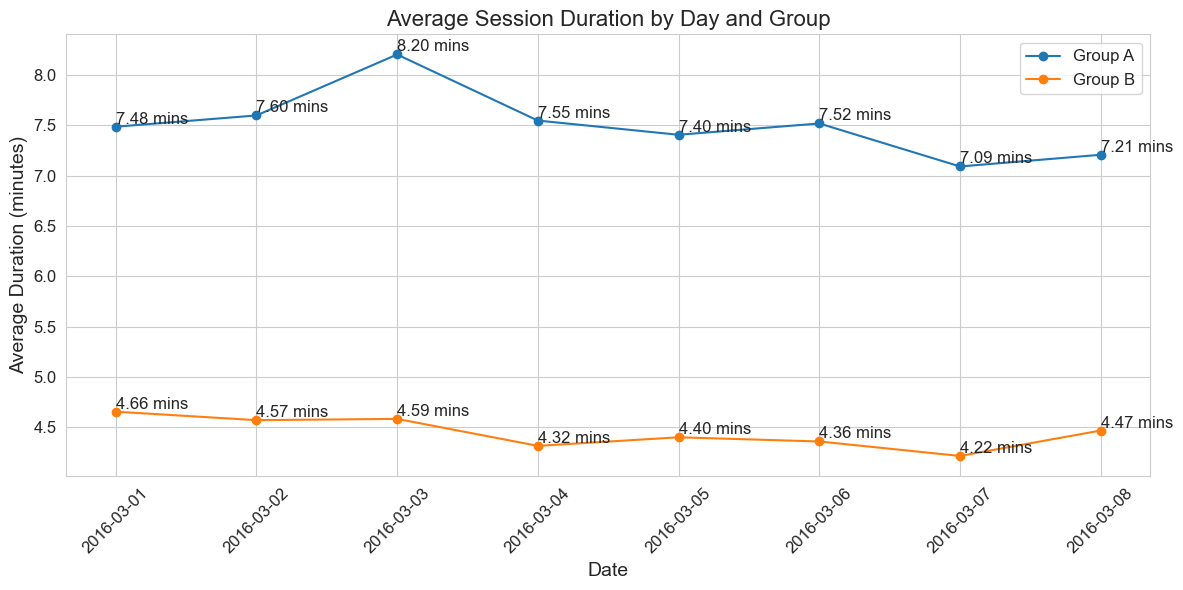

In [93]:
# Group the DataFrame by 'date' and 'group' columns and calculate the mean of 'timestamp_duration'
average_duration_per_day_group = tracking_ok.groupby(['date', 'group'])['timestamp_duration'].mean().reset_index()

# Pivot the data to have 'date' as the index and 'group' as columns
pivot_data = average_duration_per_day_group.pivot(index='date', columns='group', values='timestamp_duration')

# Create the line chart
plt.figure(figsize=(12, 6))

# Line for Group A
plt.plot(pivot_data.index, pivot_data['a'].dt.total_seconds() / 60, label='Group A', marker='o')

# Line for Group B
plt.plot(pivot_data.index, pivot_data['b'].dt.total_seconds() / 60, label='Group B', marker='o')

# Customize the plot
plt.title('Average Session Duration by Day and Group', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Duration (minutes)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Increase font size for x-axis tick labels
plt.yticks(fontsize=12)  # Increase font size for y-axis tick labels
plt.legend(fontsize=12)

# Add values to the plot with larger font size
for date, duration_a, duration_b in zip(pivot_data.index, pivot_data['a'].dt.total_seconds() / 60, pivot_data['b'].dt.total_seconds() / 60):
    plt.text(date, duration_a, f"{duration_a:.2f} mins", ha='left', va='bottom', fontsize=12)
    plt.text(date, duration_b, f"{duration_b:.2f} mins", ha='left', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

The number of clicks can be decisive when choosing one Group or another, since the number of clicks is what can make our clients decide on our platform, so we are going to calculate two more metrics:

- The number of clicks per session, depending on the duration of the sessions.

- The number of clicks per search, depending on the duration of the sessions

In [318]:
tracking_ok.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,timestamp_duration,date,day_of_week,session_duration_bin
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42,78245c2c3fba013a,b,searchResultPage,NA,cbeb66d1bc1f1bc2,5,NA,0 days 00:00:44,2016-03-01,Tuesday,"(0 days 00:00:00, 0 days 00:05:00]"
1,004690364c695f04b5d045913e1bdf7c,2016-03-01 10:39:16,78245c2c3fba013a,b,checkin,30,2f0e04bd56649f43,NA,3,0 days 00:00:44,2016-03-01,Tuesday,"(0 days 00:00:00, 0 days 00:05:00]"
2,0af62216356759fea26313e155f70809,2016-03-01 10:39:26,78245c2c3fba013a,b,checkin,40,2f0e04bd56649f43,NA,3,0 days 00:00:44,2016-03-01,Tuesday,"(0 days 00:00:00, 0 days 00:05:00]"
3,14601aeb2bf058af9380c1644e606e24,2016-03-01 10:39:06,78245c2c3fba013a,b,checkin,20,2f0e04bd56649f43,NA,3,0 days 00:00:44,2016-03-01,Tuesday,"(0 days 00:00:00, 0 days 00:05:00]"
4,33922e14b6bb5e27823481a3c44ed462,2016-03-01 10:38:56,78245c2c3fba013a,b,checkin,10,2f0e04bd56649f43,NA,3,0 days 00:00:44,2016-03-01,Tuesday,"(0 days 00:00:00, 0 days 00:05:00]"


In [107]:
# Defines bin limits for session duration (0 to 25 minutes in 5 minute increments)
duration_bins = [pd.Timedelta(minutes=i) for i in range(0, 26, 5)]

# Add a new column 'session_duration_bin' containing the bin label for each session
tracking_ok['session_duration_bin'] = pd.cut(tracking_ok['timestamp_duration'], bins=duration_bins)

# Filter the rows that correspond to the 'searchResultPage' action
search_results = tracking_ok[tracking_ok['action'] == 'searchResultPage']

# Counts the number of searches in each session duration group
search_counts = search_results.groupby('session_duration_bin')['session_id'].count()

# Show the results
print(search_counts)


session_duration_bin
(0 days 00:00:00, 0 days 00:05:00]    66779
(0 days 00:05:00, 0 days 00:10:00]    22198
(0 days 00:10:00, 0 days 00:15:00]     7014
(0 days 00:15:00, 0 days 00:20:00]     3939
(0 days 00:20:00, 0 days 00:25:00]     2288
Name: session_id, dtype: int64


C:\Users\javierheras\AppData\Local\Temp\ipykernel_10048\4024758487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_ok['session_duration_bin'] = pd.cut(tracking_ok['timestamp_duration'], bins=duration_bins)


In [108]:
# Split the data into two DataFrames, one for group 'a' and one for group 'b'
group_a_sessions = search_results[search_results['group'] == 'a']
group_b_sessions = search_results[search_results['group'] == 'b']

# Group by 'session_duration_bin' and count the number of searches for Group 'a'
search_counts_group_a = group_a_sessions.groupby('session_duration_bin')['session_id'].count()

# Group by 'session_duration_bin' and count the number of searches for Group 'b'
search_counts_group_b = group_b_sessions.groupby('session_duration_bin')['session_id'].count()

# Show results for Group 'a'
print("Number of Searches for Group 'a':")
print(search_counts_group_a)

# Show results for Group 'b'
print("\nNumber of Searches for Group 'b':")
print(search_counts_group_b)




Number of Searches for Group 'a':
session_duration_bin
(0 days 00:00:00, 0 days 00:05:00]    53144
(0 days 00:05:00, 0 days 00:10:00]    19396
(0 days 00:10:00, 0 days 00:15:00]     6928
(0 days 00:15:00, 0 days 00:20:00]     3930
(0 days 00:20:00, 0 days 00:25:00]     2282
Name: session_id, dtype: int64

Number of Searches for Group 'b':
session_duration_bin
(0 days 00:00:00, 0 days 00:05:00]    13635
(0 days 00:05:00, 0 days 00:10:00]     2802
(0 days 00:10:00, 0 days 00:15:00]       86
(0 days 00:15:00, 0 days 00:20:00]        9
(0 days 00:20:00, 0 days 00:25:00]        6
Name: session_id, dtype: int64


In [109]:
# Convert 'timestamp_duration' column to timedelta
tracking_ok['timestamp_duration'] = pd.to_timedelta(tracking_ok['timestamp_duration'])

# Defines bin limits for session duration (0 to 25 minutes in 5 minute increments)
duration_bins = [pd.Timedelta(minutes=i) for i in range(0, 26, 5)]

# Add a new column 'session_duration_bin' containing the bin label for each sessionn
tracking_ok['session_duration_bin'] = pd.cut(tracking_ok['timestamp_duration'], bins=duration_bins)

# Filter the rows that correspond to the 'visitPage' action (to calculate clicks)
click_results = tracking_ok[tracking_ok['action'] == 'visitPage']

# Splits the data into two DataFrames, one for group 'a' and one for group 'b'
group_a_clicks = click_results[click_results['group'] == 'a']
group_b_clicks = click_results[click_results['group'] == 'b']

# Group and count the number of clicks in each session duration group for group 'a'
group_a_click_counts = group_a_clicks.groupby('session_duration_bin')['session_id'].count()

# Group and count the number of clicks in each session duration group for group 'b'
group_b_click_counts = group_b_clicks.groupby('session_duration_bin')['session_id'].count()

# Show results for group 'a'
print("Clicks para el Grupo 'a':")
print(group_a_click_counts)


# Show the results for group 'b'
print("\nClicks para el Grupo 'b':")
print(group_b_click_counts)


Clicks para el Grupo 'a':
session_duration_bin
(0 days 00:00:00, 0 days 00:05:00]    16723
(0 days 00:05:00, 0 days 00:10:00]     9691
(0 days 00:10:00, 0 days 00:15:00]     3048
(0 days 00:15:00, 0 days 00:20:00]     1496
(0 days 00:20:00, 0 days 00:25:00]      717
Name: session_id, dtype: int64

Clicks para el Grupo 'b':
session_duration_bin
(0 days 00:00:00, 0 days 00:05:00]    4660
(0 days 00:05:00, 0 days 00:10:00]    2087
(0 days 00:10:00, 0 days 00:15:00]      49
(0 days 00:15:00, 0 days 00:20:00]       8
(0 days 00:20:00, 0 days 00:25:00]       6
Name: session_id, dtype: int64


C:\Users\javierheras\AppData\Local\Temp\ipykernel_10048\2559799108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_ok['timestamp_duration'] = pd.to_timedelta(tracking_ok['timestamp_duration'])
C:\Users\javierheras\AppData\Local\Temp\ipykernel_10048\2559799108.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_ok['session_duration_bin'] = pd.cut(tracking_ok['timestamp_duration'], bins=duration_bins)


In [99]:
# Calculate the ratio of the number of clicks per searchs for each bin and for Group 'A'
group_a_click_ratio = group_a_click_counts / search_counts_group_a

# Calculate the ratio of the number of clicks per searchs for each bin and for Group 'B'
group_b_click_ratio = group_b_click_counts / search_counts_group_b

# Show the ratios for Group 'A'
print("Click Ratio per Search for Group 'A':")
print(group_a_click_ratio)

# Show the ratios for Group 'B'
print("\nClick Ratio per Search for Group 'B':")
print(group_b_click_ratio)


Click Ratio per Search for Group 'A':
session_duration_bin
(0 days 00:00:00, 0 days 00:05:00]    0.314673
(0 days 00:05:00, 0 days 00:10:00]    0.499639
(0 days 00:10:00, 0 days 00:15:00]    0.439954
(0 days 00:15:00, 0 days 00:20:00]    0.380662
(0 days 00:20:00, 0 days 00:25:00]    0.314198
Name: session_id, dtype: float64

Click Ratio per Search for Group 'B':
session_duration_bin
(0 days 00:00:00, 0 days 00:05:00]    0.341768
(0 days 00:05:00, 0 days 00:10:00]    0.744825
(0 days 00:10:00, 0 days 00:15:00]    0.569767
(0 days 00:15:00, 0 days 00:20:00]    0.888889
(0 days 00:20:00, 0 days 00:25:00]    1.000000
Name: session_id, dtype: float64


We can see in the graph that the click/search ratio is higher in group B than in group A, so users in group B need fewer searches to make the clicks.

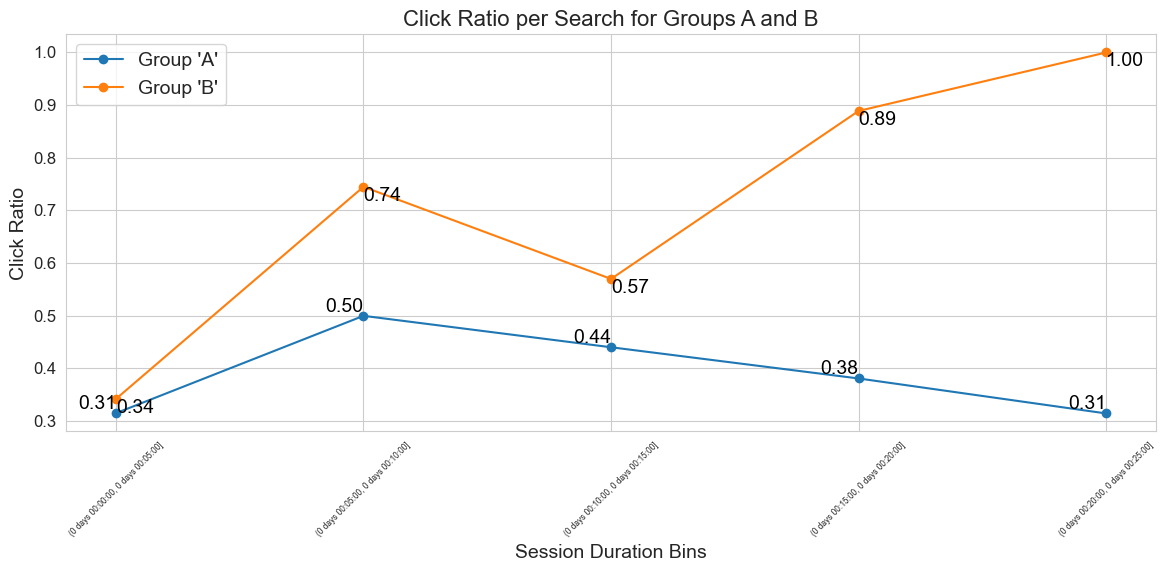

In [178]:
# Define the bin labels
bin_labels = [str(bin) for bin in group_a_click_ratio.index]

# Create a figure and axes for the chart
plt.figure(figsize=(12, 6))

# Plot the line for Group 'A'
plt.plot(bin_labels, group_a_click_ratio, marker='o', label="Group 'A'")

# Plot the line for Group 'B'
plt.plot(bin_labels, group_b_click_ratio, marker='o', label="Group 'B'")

# Add values to the data points for Group 'A' in black and larger font
for x, y in zip(bin_labels, group_a_click_ratio):
    plt.text(x, y, f'{y:.2f}', ha='right', va='bottom', fontsize=14, color='black')

# Add values to the data points for Group 'B' in black and larger font
for x, y in zip(bin_labels, group_b_click_ratio):
    plt.text(x, y, f'{y:.2f}', ha='left', va='top', fontsize=14, color='black')

# Customize the chart
plt.title('Click Ratio per Search for Groups A and B', fontsize=16)
plt.xlabel('Session Duration Bins', fontsize=14)
plt.ylabel('Click Ratio', fontsize=14)
plt.xticks(rotation=45, fontsize=6)  # Increase x-axis tick font size
plt.yticks(fontsize=12)  # Increase y-axis tick font size

# Add a legend to the chart with larger font size
plt.legend(fontsize=14)

# Show the chart
plt.tight_layout()
plt.grid(True)
plt.show()


In [103]:
# Group the data by 'session_duration_bin' and calculate unique 'session_id' count for each bin
unique_sessions_by_bin = search_results.groupby('session_duration_bin')['session_id'].nunique()

# Display the unique session counts for each bin
print("Unique Session Counts by Duration Bin:")
print(unique_sessions_by_bin)

Unique Session Counts by Duration Bin:
session_duration_bin
(0 days 00:00:00, 0 days 00:05:00]    28869
(0 days 00:05:00, 0 days 00:10:00]     8990
(0 days 00:10:00, 0 days 00:15:00]     1424
(0 days 00:15:00, 0 days 00:20:00]      542
(0 days 00:20:00, 0 days 00:25:00]      204
Name: session_id, dtype: int64


In [104]:
# Filter the data for Group 'A'
group_a_data = search_results[search_results['group'] == 'a']

# Filter the data for Group 'B'
group_b_data = search_results[search_results['group'] == 'b']

# Group the data for Group 'A' by 'session_duration_bin' and calculate unique 'session_id' count for each bin
unique_sessions_group_a = group_a_data.groupby('session_duration_bin')['session_id'].nunique()

# Group the data for Group 'B' by 'session_duration_bin' and calculate unique 'session_id' count for each bin
unique_sessions_group_b = group_b_data.groupby('session_duration_bin')['session_id'].nunique()

# Display the unique session counts for Group 'A' by duration bin
print("Unique Session Counts for Group 'A' by Duration Bin:")
print(unique_sessions_group_a)

# Display the unique session counts for Group 'B' by duration bin
print("\nUnique Session Counts for Group 'B' by Duration Bin:")
print(unique_sessions_group_b)


Unique Session Counts for Group 'A' by Duration Bin:
session_duration_bin
(0 days 00:00:00, 0 days 00:05:00]    20319
(0 days 00:05:00, 0 days 00:10:00]     6703
(0 days 00:10:00, 0 days 00:15:00]     1370
(0 days 00:15:00, 0 days 00:20:00]      534
(0 days 00:20:00, 0 days 00:25:00]      198
Name: session_id, dtype: int64

Unique Session Counts for Group 'B' by Duration Bin:
session_duration_bin
(0 days 00:00:00, 0 days 00:05:00]    8550
(0 days 00:05:00, 0 days 00:10:00]    2287
(0 days 00:10:00, 0 days 00:15:00]      54
(0 days 00:15:00, 0 days 00:20:00]       8
(0 days 00:20:00, 0 days 00:25:00]       6
Name: session_id, dtype: int64


In [105]:
# Calculate the ratio of the number of clicks per session for each bin and for Group 'A'
group_a_click_ratio_session = group_a_click_counts / unique_sessions_group_a

# Calculate the ratio of the number of clicks per session for each bin and for Group 'B'
group_b_click_ratio_session = group_b_click_counts / unique_sessions_group_b

# Show the ratios for Group 'A'
print("Click Ratio per Session for Group 'A':")
print(group_a_click_ratio_session)

# Show the ratios for Group 'B'
print("\nClick Ratio per Session for Group 'B':")
print(group_b_click_ratio_session)


Click Ratio per Session for Group 'A':
session_duration_bin
(0 days 00:00:00, 0 days 00:05:00]    0.823023
(0 days 00:05:00, 0 days 00:10:00]    1.445771
(0 days 00:10:00, 0 days 00:15:00]    2.224818
(0 days 00:15:00, 0 days 00:20:00]    2.801498
(0 days 00:20:00, 0 days 00:25:00]    3.621212
Name: session_id, dtype: float64

Click Ratio per Session for Group 'B':
session_duration_bin
(0 days 00:00:00, 0 days 00:05:00]    0.545029
(0 days 00:05:00, 0 days 00:10:00]    0.912549
(0 days 00:10:00, 0 days 00:15:00]    0.907407
(0 days 00:15:00, 0 days 00:20:00]    1.000000
(0 days 00:20:00, 0 days 00:25:00]    1.000000
Name: session_id, dtype: float64


In this case, the clicks per session ratio is higher in group A, so since the sessions are longer in this group, people make more clicks per session than group B, and it is also seen as that proportion. increases with increasing session duration

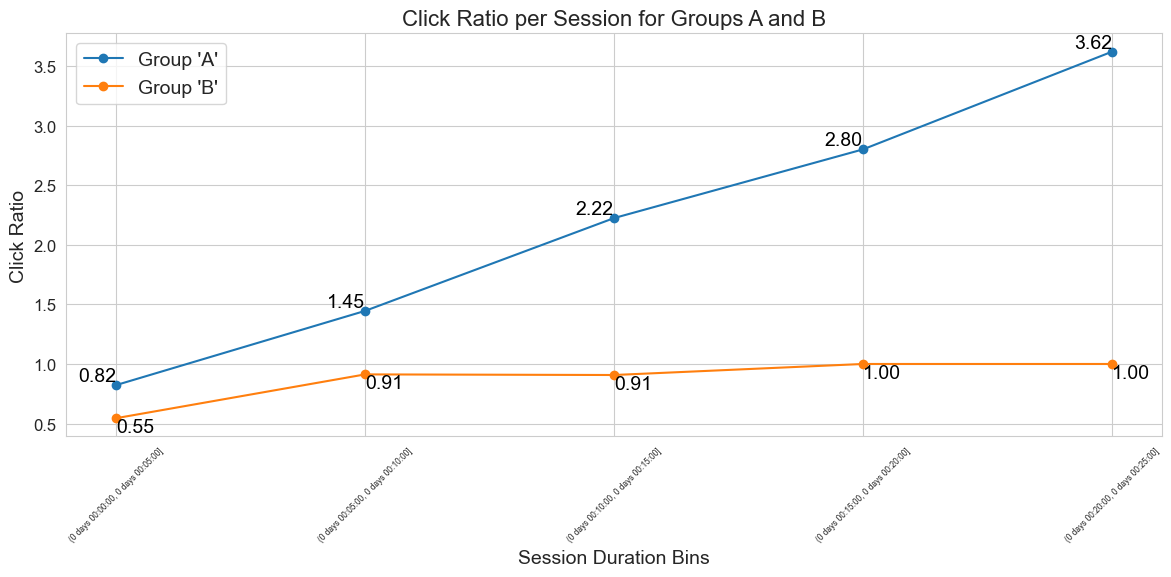

In [204]:
# Define the bin labels
bin_labels = [str(bin) for bin in group_a_click_ratio_session.index]

# Create a figure and axes for the chart
plt.figure(figsize=(12, 6))

# Plot the line for Group 'A'
plt.plot(bin_labels, group_a_click_ratio_session, marker='o', label="Group 'A'")

# Plot the line for Group 'B'
plt.plot(bin_labels, group_b_click_ratio_session, marker='o', label="Group 'B'")

# Add values to the data points for Group 'A' in black and larger font
for x, y in zip(bin_labels, group_a_click_ratio_session):
    plt.text(x, y, f'{y:.2f}', ha='right', va='bottom', fontsize=14, color='black')

# Add values to the data points for Group 'B' in black and larger font
for x, y in zip(bin_labels, group_b_click_ratio_session):
    plt.text(x, y, f'{y:.2f}', ha='left', va='top', fontsize=14, color='black')

# Customize the chart
plt.title('Click Ratio per Session for Groups A and B', fontsize=16)
plt.xlabel('Session Duration Bins', fontsize=14)
plt.ylabel('Click Ratio', fontsize=14)
plt.xticks(rotation=45, fontsize=6)  # Increase x-axis tick font size
plt.yticks(fontsize=12)  # Increase y-axis tick font size

# Add a legend to the chart with larger font size
plt.legend(fontsize=14)

# Show the chart
plt.tight_layout()
plt.grid(True)
plt.show()



# 3.Executive summary

As we have seen previously, we have a dataset with which, by calculating some metrics, we will be able to make decisions about which of our solutions works best.

We have seen how group A has a higher number than group B, with any of them being representative to continue carrying out the A/B test.

Next we proceed to highlight the most important points of our analysis.

1.- CLICK-THROUGH RATE
     
We see that the average CTR is higher in Group A with 66.91%, and lower in Group B with a percentage of 61.25%.

In the weekly distribution of the CTR, we also see that most days it is higher in Group A than in Group B.

Therefore, taking this metric into account, the Group A option is preferable, since it has a greater number of click sessions, making it easier to monetize it.


2.- WHICH RESULT DO PEOPLE TEND TO TRY FIRST?HOW DOES IT CHANGE DAY TO DAY?

On this occasion, in both Group A and Group B, the link position that users choose first is 1, with the following percentages.

Group A: 52.59%
Group B: 68.05%

We see how there is a higher percentage of users in Group B who choose the result located in the first position, so in this group users find what they are looking for more easily.

In the weekly distribution of the percentage, we can see how in Group A, the previous low percentage is due to the high number of users who first use results in the N/A position, that is, they come externally.


3.- ZERO RESULT RATE

Now we are going to measure the Zero Result Rate, this reflects the number of searches in which no results are achieved, giving us information about the quality of the information offered to users or the operation of the search engine, in short it evaluates the user experience.

The ZRR percentages in group A is 17.93%, and that of Group B is 14.47%, so in this case Group B offers a better experience to users.


4.- DURATION OF THE SESSION.

  In this section, the duration of the sessions will be compared based on other variables, these being the following:

A) Duration of Sessions/Day of the week

It can be seen in the graph that the duration of the sessions in Group A is 7.32 minutes, and in Group B it is 4.26 minutes. Users stay longer in Group A sessions.

B) Duration of Sessions/Click per session

We have calculated, depending on the duration of the session, the clicks/session, and you can see how on this occasion, the users of Group A, make a greater number of clicks in each session, this number being greater the longer it is. the session.

On the other hand, this ratio in Group b does not exceed 1, with no more clicks being obtained even if the sessions last longer.

C) Duration of Sessions/Clicks per search

On this occasion, Group B users need a smaller number of searches to click, improving the ratio with the longer duration of the sessions.


For all of the above, and based on the fact that monetization by users is largely due to the number of searches, clicks and time on the domain, we believe that the Group A option is the winner, since it keeps users longer. time in the sessions, performing more searches, and more total clicks.

Although option B seems to offer users a better experience, it is not enough to keep them longer, or for the number of clicks or searches to be comparable.









































